In [25]:
import os
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report
import gradio as gr

from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import EfficientNetV2B0
from tensorflow.keras.applications.efficientnet import preprocess_input
warnings.filterwarnings('ignore')
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)


In [2]:
trainpath = "C:/E-Waste-Project/Dataset/train"
validpath = "C:/E-Waste-Project/Dataset/val"
testpath  = "C:/E-Waste-Project/Dataset/test"

In [4]:
datatrain = tf.keras.utils.image_dataset_from_directory(trainpath, shuffle=True, image_size=(128, 128), batch_size=32)
datavalid = tf.keras.utils.image_dataset_from_directory(validpath, shuffle=True, image_size=(128, 128), batch_size=32)
datatest = tf.keras.utils.image_dataset_from_directory(testpath, shuffle=False, image_size=(128, 128), batch_size=32)

Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [5]:
class_names = datatrain.class_names

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
datatrain = datatrain.prefetch(buffer_size=AUTOTUNE)
datavalid = datavalid.prefetch(buffer_size=AUTOTUNE)
datatest = datatest.prefetch(buffer_size=AUTOTUNE)

In [7]:
base_model = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

In [8]:
inputs = layers.Input(shape=(128, 128, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(len(class_names), activation='softmax')(x)
model = models.Model(inputs, outputs)

In [11]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [14]:
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = callbacks.ModelCheckpoint('best_model.keras', monitor='val_accuracy', save_best_only=True)

In [15]:
history = model.fit(datatrain, validation_data=datavalid, epochs=20, callbacks=[earlystop, checkpoint])

Epoch 1/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 65s 871ms/step - accuracy: 0.9340 - loss: 0.2695 - val_accuracy: 0.9433 - val_loss: 0.2205
Epoch 2/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 82s 878ms/step - accuracy: 0.9472 - loss: 0.2093 - val_accuracy: 0.9500 - val_loss: 0.1964
Epoch 3/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 790ms/step - accuracy: 0.9607 - loss: 0.1628 - val_accuracy: 0.9533 - val_loss: 0.1821
Epoch 4/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 66s 575ms/step - accuracy: 0.9561 - loss: 0.1608 - val_accuracy: 0.9533 - val_loss: 0.1727
Epoch 5/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 85s 611ms/step - accuracy: 0.9682 - loss: 0.1347 - val_accuracy: 0.9567 - val_loss: 0.1689
Epoch 6/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 53s 713ms/step - accuracy: 0.9718 - loss: 0.1249 - val_accuracy: 0.9667 - val_loss: 0.1603
Epoch 7/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 76s 628ms/step - accuracy: 0.9685 - loss: 0.1194 - val_accuracy: 0.9667 - val_loss: 0.1542
Epoch 8/20
75/75 ━━━━━━━━━━━━━━━━━━━━ 103s 898ms/step - accuracy: 0.9776 - loss: 0.0966 - val_acc

In [16]:
model = load_model('best_model.keras')

In [17]:
loss, acc = model.evaluate(datatest)
print(f"Test Accuracy: {acc*100:.2f}%")

10/10 ━━━━━━━━━━━━━━━━━━━━ 17s 492ms/step - accuracy: 0.9209 - loss: 0.2026
Test Accuracy: 94.33%


In [18]:
y_true = []
y_pred = []

for images, labels in datatest:
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 537ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 637ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 613ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 530ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


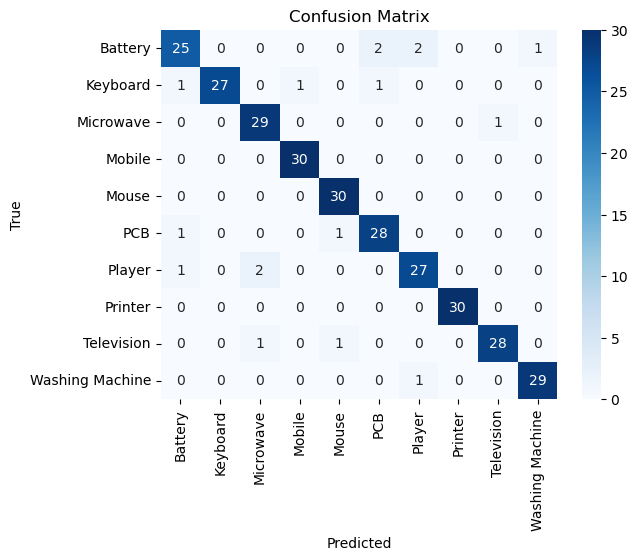

In [19]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [20]:
print(classification_report(y_true, y_pred, target_names=class_names))

                 precision    recall  f1-score   support

        Battery       0.89      0.83      0.86        30
       Keyboard       1.00      0.90      0.95        30
      Microwave       0.91      0.97      0.94        30
         Mobile       0.97      1.00      0.98        30
          Mouse       0.94      1.00      0.97        30
            PCB       0.90      0.93      0.92        30
         Player       0.90      0.90      0.90        30
        Printer       1.00      1.00      1.00        30
     Television       0.97      0.93      0.95        30
Washing Machine       0.97      0.97      0.97        30

       accuracy                           0.94       300
      macro avg       0.94      0.94      0.94       300
   weighted avg       0.94      0.94      0.94       300



In [26]:
def predict_image(img):
    img = img.resize((128, 128))
    img = np.array(img)
    img = preprocess_input(img)  # Use EfficientNet's preprocessing
    img = np.expand_dims(img, axis=0)
    preds = model.predict(img)
    return {class_names[i]: float(preds[0][i]) for i in range(len(class_names))}

In [27]:
interface = gr.Interface(fn=predict_image, inputs=gr.Image(type="pil"), outputs=gr.Label())
interface.launch()

* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.
